Author: Neven Caplar and the LINCC Frameworks team

Last updated: November 13, 2025

# Initial LSDB

In this notebook we'll show how to:
- Import DASK client
- Load object and source catalogs (lazily)
- Show HATS partitioning with ZTF objects and sources
- Perform crossmatching with existing `HATS` catalogs across the whole sky
- Save the results of a science workflow to disk
- Discuss the performance

There is also an "Extra topics" section with details on margin caches.

In [1]:
# do you need to install the package?
# if yes, uncomment the line below and restart the kernel
# %pip install -U lsdb

In [2]:
# Standard library imports
import os
# Set to the maximum number of threads you want to allow
os.environ["NUMEXPR_MAX_THREADS"] = "4"

# Third-party imports
import numpy as np
import pandas as pd
import dask
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
import warnings
from upath import UPath

# Local library-specific imports
import lsdb
from lsdb import ConeSearch

# Jupyter-specific settings and magic commands
%matplotlib inline

# Configuration settings
warnings.simplefilter("ignore")
logging.getLogger("numexpr.utils").setLevel(logging.WARNING)
logging.getLogger("distributed").setLevel(logging.WARNING)
rcParams["savefig.dpi"] = 550
rcParams["font.size"] = 20
plt.rc("font", family="serif")
mpl.rcParams["axes.linewidth"] = 2
dask.config.set({"dataframe.convert-string": False})

print(f"Version of lsdb is {lsdb.__version__}")

Version of lsdb is 0.6.7


In [3]:
# Define the six fields from Data Preview 1 with RA and Dec coordinates
fields = {
    "ECDFS": (53.13, -28.10),  # Extended Chandra Deep Field South
    "EDFS": (59.10, -48.73),  # Euclid Deep Field South
    "Rubin_SV_38_7": (37.86, 6.98),  # Low Ecliptic Latitude Field
    "Rubin_SV_95_-25": (95.00, -25.00),  # Low Galactic Latitude Field
    "47_Tuc": (6.02, -72.08),  # 47 Tuc Globular Cluster
    "Fornax_dSph": (40.00, -34.45)  # Fornax Dwarf Spheroidal Galaxy
}

# Define a 2-degree (2*3600 arcseconds) search radius
radius_arcsec = 2 * 3600  # Convert 2 degree to arcseconds
# Create six cone searches
cones = {name: ConeSearch(ra=ra, dec=dec, radius_arcsec=radius_arcsec) for name, (ra, dec) in fields.items()}

# Import DASK client


LSDB uses the Dask framework for parallel and out-of-memory computing. Dask is a flexible library for parallel computing in Python that scales from single machines to large clusters. When using LSDB, it is usually worth setting up a Dask cluster (local or multi-node) to take advantage of parallel computing. With no Dask cluster, LSDB would use a single CPU core for the computations, which is prohibitive for large datasets.

In [4]:
client = Client(n_workers=4, memory_limit="4GiB", threads_per_worker=1)

# Print the dashboard link and port
print(f"Dask is running at: {client.dashboard_link}")

Dask is running at: https://nevencaplar.nb.data.lsst.cloud/nb/user/nevencaplar/proxy/8787/status


We have numerous public catalogs available through data.lsdb.io. Some of them are hosted on machine hosted by University of Washington, and some of them are on cloud (provided by either IPAC, or Space Telescope)



Let’s start by opening a HATS formatted Catalog in LSDB. Use the lsdb.open_catalog() function to open a catalog object. We’ll pass in the URL to open the Zwicky Transient Facility Data Release 14 Catalog, and GAIA DR3 Catalog.

In [5]:
catalogs_dir = "https://data.lsdb.io/hats"

# Gaia
gaia_path = f"{catalogs_dir}/gaia_dr3/gaia"

# ZTF
ztf_object_path = f"{catalogs_dir}/ztf_dr14/ztf_object"
ztf_source_path = f"{catalogs_dir}/ztf_dr14/ztf_source"
ztf_object_margin_path = f"{catalogs_dir}/ztf_dr14/ztf_object_10arcs"

In [6]:
ztf_object = lsdb.open_catalog(
    ztf_object_path,
    columns=["ra", "dec", "ps1_objid", "nobs_r", "mean_mag_r"],
)
ztf_object

,ra,dec,ps1_objid,nobs_r,mean_mag_r
npartitions=2352,,,,,
"Order: 3, Pixel: 0",double[pyarrow],double[pyarrow],int64[pyarrow],int32[pyarrow],double[pyarrow]
"Order: 3, Pixel: 1",...,...,...,...,...
...,...,...,...,...,...
"Order: 4, Pixel: 3070",...,...,...,...,...
"Order: 4, Pixel: 3071",...,...,...,...,...


We’ve specified 5 columns to load here. It’s important for performance to select only the columns you need for your workflow. Without specifying any columns, all available columns will be loaded when the workflow is executed, making everything much slower and using much more memory.

Catalogs define a set of default columns that are loaded if you don’t specify your own list, in part to prevent you from incurring more I/O usage than you expected. You can always see the full set of columns available with the lsdb.catalog.Catalog.all_columns property.

In [7]:
ztf_object.all_columns

['ps1_objid',
 'ra',
 'dec',
 'ps1_gMeanPSFMag',
 'ps1_rMeanPSFMag',
 'ps1_iMeanPSFMag',
 'nobs_g',
 'nobs_r',
 'nobs_i',
 'mean_mag_g',
 'mean_mag_r',
 'mean_mag_i',
 'Norder',
 'Dir',
 'Npix']

## Lazy Operations

When working with large datasets, there is too much data to be loaded into memory at once. To get around this, LSDB uses the HATS format which partitions a catalog into HEALPix cells and works on one partition at a time. This also allows the computation to be parallelized to work on multiple partitions at once. In order to efficiently carry out pipelines of operations though, it's better to batch operations so that multiple operations can be done back to back on the same partition instead of having to load and save each partition from storage after every operation.

For this reason, operations in LSDB are performed 'lazily'. This means when a catalog is read using `open_catalog`, the actual catalog data isn't being read from storage. Instead, it only loads the metadata such as the column schema and the HEALPix structure of the partitions. When an operation like `cone_search` is called on a catalog, the data is not actually loaded and operated on when the line of code is executed. Instead, the catalog keeps track of the operations that it needs to perform so the entire pipeline can be efficiently run later. This also allows us to optimize the pipeline by only loading the partitions that are necessary. For example when performing a cone search like we do here, we only need the partitions that have data within the cone.

![lazy loading diagram](https://raw.githubusercontent.com/astronomy-commons/lsdb/main/docs/_static/lazy_diagram.svg)

So when we look at a catalog that has been lazy loaded we see the DataFrame without the data, just the columns and the number of partitions (including the HATS index of each partition encoding which HEALPix cell the partition is in). 

In [8]:
%%time

# Define a 0.7 degree cone region of interest
# This covers the so called `Rubin_SV_95_-25` field, one of Data Preview 1 fields
cone_search = ConeSearch(ra=95, dec=-25, radius_arcsec=0.7 * 3600)

# Load lite version of Gaia DR3 (RA and DEC data only)
gaia_lite = lsdb.open_catalog(gaia_path, columns=["ra", "dec"], search_filter=cone_search)

# Load all Gaia data
hats_gaia = lsdb.open_catalog(gaia_path)

CPU times: user 3.08 s, sys: 288 ms, total: 3.37 s
Wall time: 7.98 s


So when we look at a catalog that has been lazy loaded we see the DataFrame without the data, just the columns and the number of partitions (including the HATS index of each partition encoding which HEALPix cell the partition is in).



In [9]:
gaia_lite

,ra,dec
npartitions=4,,
"Order: 3, Pixel: 321",double[pyarrow],double[pyarrow]
"Order: 3, Pixel: 323",...,...
"Order: 4, Pixel: 1298",...,...
"Order: 3, Pixel: 326",...,...


To load the data and perform the operations, call compute() which will load the necessary data and perform all the operations that have been called, and return a Pandas DataFrame with the results.

In [10]:
# around 20 seconds expected
gaia_lite_computed = gaia_lite.compute()

The Figure belows shows the simple graph that DASK makes to ''compute'' this operation.

In [11]:
#TODO:  Drawing dask graphs with the graphviz visualization engine requires the `graphviz` python library and the `graphviz` system library. 
# gaia_lite._ddf.visualize()

In [12]:
gaia_lite_computed

,ra,dec
_healpix_29,,
1450053251443354521,95.230932,-25.656355
1450053367513191047,95.277507,-25.651934
...,...,...
1468182870336026869,95.385895,-24.397842
1468182870426027146,95.385674,-24.397763


## HATS (Hierarchal Adaptive Tiling Scheme) Partitioning

To make it easier and more efficient to perform operations in parallel, HATS partitions contain roughly the same number of rows. This is done by using different HEALPix pixel sizes for different parts of the sky depending on the density of sources. This means catalogs with more rows will have smaller pixels for each partition, and so will have more partitions overall. We can see this below with the ZTF object and source catalogs, where the source catalog with many more data points has more partitions to keep the size of each partition consistent.

In [13]:
%%time
ztf_object = lsdb.open_catalog(ztf_object_path, columns=["ra", "dec"])  # ZTF Object
ztf_source = lsdb.open_catalog(ztf_source_path, columns=["ra", "dec"])  # ZTF Source

CPU times: user 2.19 s, sys: 142 ms, total: 2.33 s
Wall time: 7.01 s


In [14]:
# Catalog is only lazy loaded, and with only 2 columns 
ztf_object

,ra,dec
npartitions=2352,,
"Order: 3, Pixel: 0",double[pyarrow],double[pyarrow]
"Order: 3, Pixel: 1",...,...
...,...,...
"Order: 4, Pixel: 3070",...,...
"Order: 4, Pixel: 3071",...,...


In [15]:
# This catalog is also only lazy loaded. Note how many more partitions it has.
ztf_source

,ra,dec
npartitions=41679,,
"Order: 4, Pixel: 0",double[pyarrow],double[pyarrow]
"Order: 4, Pixel: 1",...,...
...,...,...
"Order: 5, Pixel: 12286",...,...
"Order: 5, Pixel: 12287",...,...


We can see this difference in partition pixel sizes by plotting the HEALPix pixels of the partitions in the catalogs.

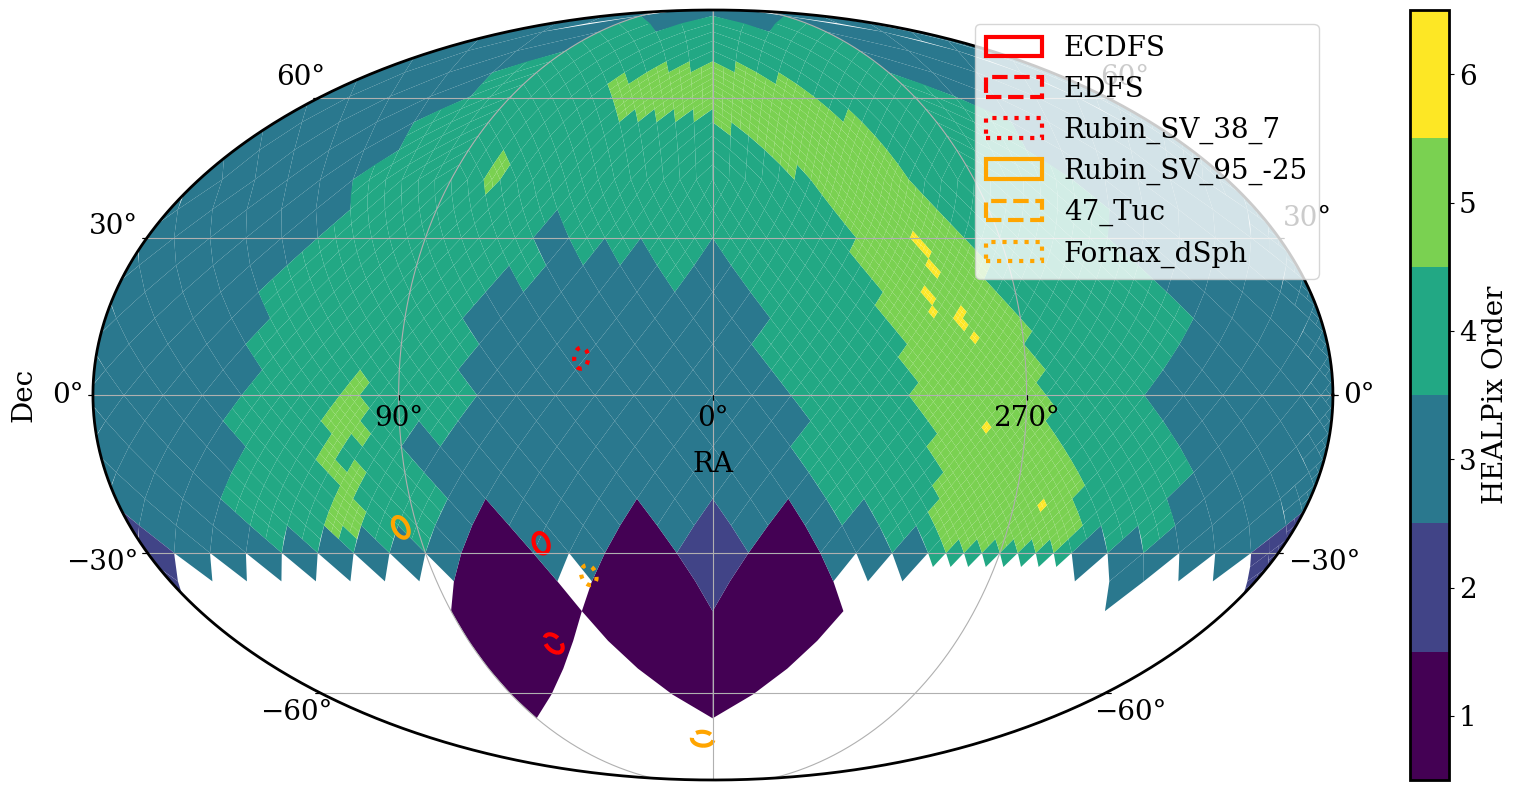

In [16]:
# Assign colors and linestyles
# Red for extragalactic fields, orange for dense fields
field_styles = {
    "ECDFS": ("red", "solid"),
    "EDFS": ("red", "dashed"),
    "Rubin_SV_38_7": ("red", "dotted"),
    "Rubin_SV_95_-25": ("orange", "solid"),
    "47_Tuc": ("orange", "dashed"),
    "Fornax_dSph": ("orange", "dotted"),
}

# Create the figure
fig = plt.figure(figsize=(20, 10))

# Plot the pixel density map for the ZTF object
_, ax = ztf_object.plot_pixels(fig=fig)

# Loop through all six fields and plot them with assigned colors and linestyles
for name, cone in cones.items():
    color, linestyle = field_styles[name]  # Get assigned color and linestyle
    cone.plot(ec=color, facecolor="none", label=name, linewidth=3, linestyle=linestyle)

# Add a legend to distinguish the different fields (positioned in the upper right)
plt.legend(loc="upper right")

# Show the plot
plt.show()

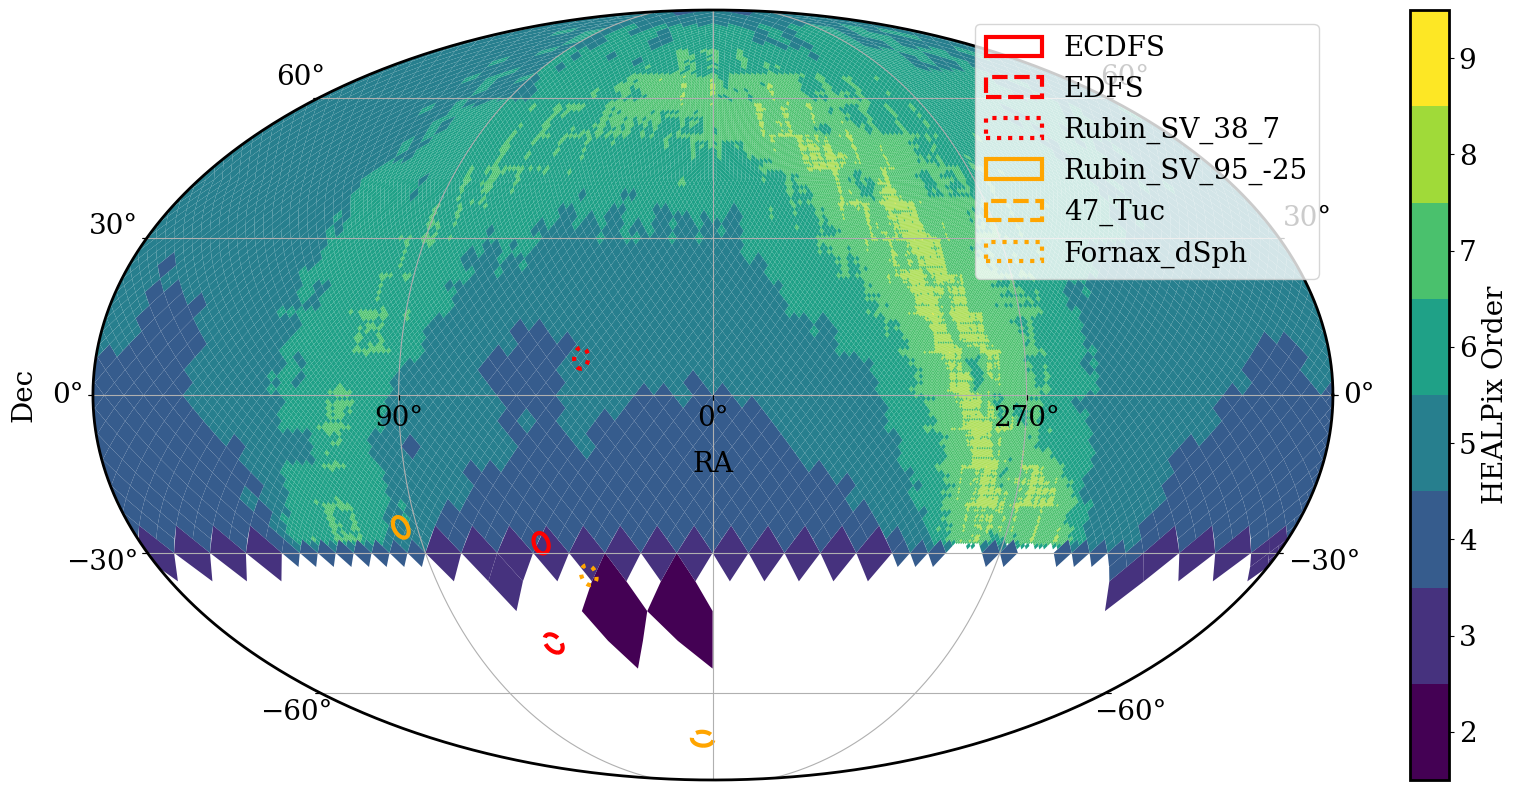

In [17]:
# Plot the pixel density map for ZTF sources
# Create the figure
fig2 = plt.figure(figsize=(20, 10))

# Plot the pixel density map for the ZTF object
_, ax = ztf_source.plot_pixels(fig=fig2)

# Loop through all six fields and plot them with assigned colors and linestyles
for name, cone in cones.items():
    color, linestyle = field_styles[name]  # Get assigned color and linestyle
    cone.plot(ec=color, facecolor="none", label=name, linewidth=3, linestyle=linestyle)

# Add a legend to distinguish the different fields (positioned in the upper right)
plt.legend(loc="upper right")

# Show the plot
plt.show()

# Crossmatching across the whole sky

We are now ready to do a crossmatch between ZTF and GAIA. Let us try to find ZTF objects that have more than 50 detections in both r- and g- bands, and let us select FGK dwarf stars (with temperature, surface gravity, and parallax cuts). We will use power of Parquet and load only the columns that we need, which will substantially speed up the analysis.

In [18]:
%%time
# Load ZTF and specify the margin cache (see extra topics at the end)!
ztf_object_full = lsdb.open_catalog(ztf_object_path, margin_cache=ztf_object_margin_path, columns=["ra", "dec", 'nobs_g', 'nobs_r'], search_filter=cone_search)

# Load Gaia DR3 with columns we need
gaia_ra_dec = lsdb.open_catalog(gaia_path, 
                                columns=["ra", "dec", "parallax", 'parallax_over_error', 'teff_gspphot', 'logg_gspphot', 'classprob_dsc_combmod_star'], 
                                search_filter=cone_search)

CPU times: user 435 ms, sys: 67.7 ms, total: 502 ms
Wall time: 5.72 s


In [19]:
%%time
# crossmatch ZTF + Gaia + filter to get FGK dwarf stars 
_all_sky_object = gaia_ra_dec.crossmatch(ztf_object_full).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5"
)

CPU times: user 4.7 s, sys: 230 ms, total: 4.93 s
Wall time: 4.78 s


In [20]:
# This will take a while, as it is a crossmatch of two large catalogs that we have to pull over the network
gaia_ztf_xmatch = _all_sky_object.compute()

In [21]:
# This is the dataframe with all the computed objects
gaia_ztf_xmatch

,ra_gaia,dec_gaia,parallax_gaia,parallax_over_error_gaia,teff_gspphot_gaia,logg_gspphot_gaia,classprob_dsc_combmod_star_gaia,ra_ztf_dr14,dec_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,_dist_arcsec
_healpix_29,,,,,,,,,,,,
1450074785694414494,95.001613,-25.695083,0.262542,5.170745,5849.858887,4.5408,0.99994,95.001602,-25.695078,114,407,0.037825
1450074883510774598,94.946329,-25.689448,0.428121,9.570097,5391.161133,4.5738,0.999972,94.946327,-25.689445,115,411,0.010681
...,...,...,...,...,...,...,...,...,...,...,...,...
1468176417832374306,95.475166,-24.454984,0.292271,7.298067,6355.506836,4.5392,0.999912,95.475166,-24.454965,118,416,0.068187
1468182274929386810,95.450075,-24.458341,1.915897,36.170208,5452.439453,4.6829,0.998258,95.450062,-24.458342,109,408,0.044942


Ok, 703 objects in this small part of the sky! Let us now visualize the GAIA objects that got matched in a small patch of the sky. Orange circle shows the cone contaning one of the galactic Rubin Data Preview 1 fields.

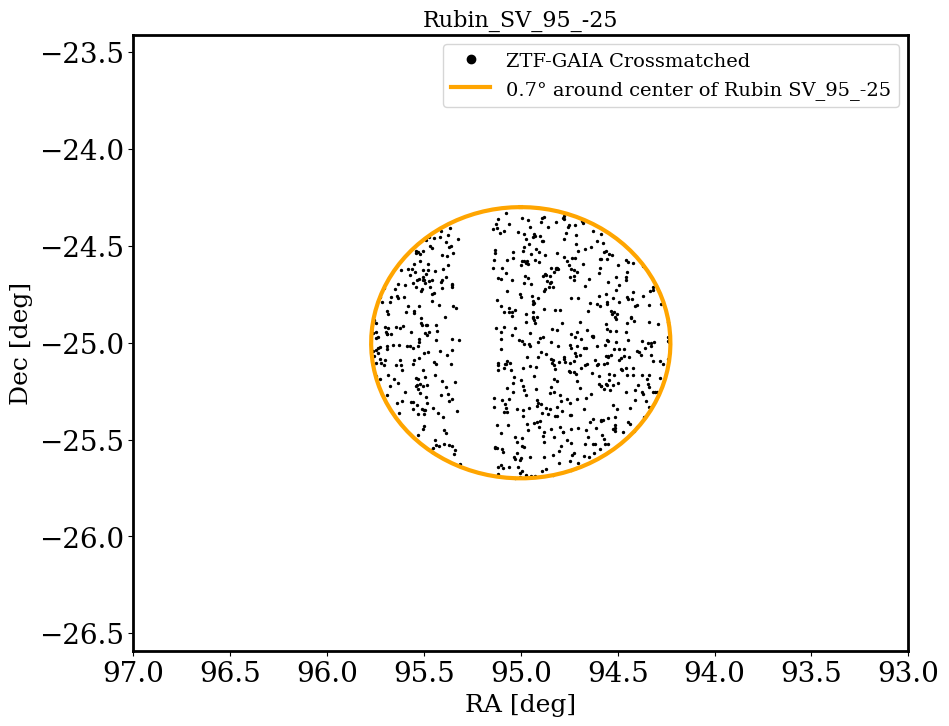

In [22]:
# Extract the center coordinates from the cones dictionary for Rubin_SV_95_-25
ra_center, dec_center = cones["Rubin_SV_95_-25"].ra, cones["Rubin_SV_95_-25"].dec
center = SkyCoord(ra=ra_center * u.deg, dec=dec_center * u.deg, frame="icrs")

# Create the figure
plt.figure(figsize=(10, 8))

# Main scatter plots
plt.scatter(gaia_ztf_xmatch["ra_gaia"].values, gaia_ztf_xmatch["dec_gaia"].values, color="black", s=2, label="ZTF-GAIA Crossmatched")

# Plot a 1-degree radius circle around the center
circle_coord = center.directional_offset_by(
    position_angle=np.linspace(0, 360, 100) * u.deg, separation=0.7 * u.deg
)
plt.plot(circle_coord.ra.deg, circle_coord.dec.deg, color="orange", lw=3, label="Rubin SV_95_-25 field")

# Ensure axis limits are set correctly (adjusting around the field center)
plt.axis([ra_center - 2, ra_center + 2, dec_center - 2, dec_center + 2])  
plt.gca().set_autoscale_on(False)  # Prevent auto-rescaling

# Ensure equal aspect ratio for RA and Dec
plt.gca().set_aspect("equal", adjustable="datalim")
# Labels and legend with bigger font and matching labels
legend_labels = ["ZTF-GAIA Crossmatched", "0.7° around center of Rubin SV_95_-25"]
legend_colors = ["black", "orange"]
legend_handles = [
    plt.Line2D([0], [1], color="black", marker="o", linestyle="None", markersize=6, label="ZTF-GAIA Crossmatched"),
    plt.Line2D([0], [1], color="orange", lw=3, linestyle="-", label="0.7° around center of Rubin SV_95_-25")
]

plt.legend(legend_handles, legend_labels, loc="upper right", fontsize=14, scatterpoints=1)

# Labels
plt.xlabel("RA [deg]", fontsize=18)
plt.ylabel("Dec [deg]", fontsize=18)

# Adjust the x-axis direction
plt.gca().invert_xaxis()

# Title to indicate the field being plotted
plt.title("Rubin_SV_95_-25", fontsize=16)

# Show the plot
plt.show()

## Export catalogs to disk

Once the analysis is complete we can export our results in the HATS format. To do so you would uncomment the line below. You need to provide a base directory path for your catalog and you should also provide a catalog name that expresses the nature of your data. You can load the saved catalog back via LSDB, or you can load the parquet files that are saved to disk with any other parquet reader of your choice.

In [23]:
# Export crossmatched data to disk
gaia_ztf_xmatch.to_parquet(path="gaia_ztf_xmatch")

# Crossmatching Performance

Catalogs have valuable metadata about their partitioning structure (e.g. the sky coverage and the order of the pixels at each point in the sky). LSDB takes advantage of this information for operations like joining/crossmatching to identify pairs of partitions that are spatially close to each other in the sky. Each core available to your distributed Dask client will process a pair of partitions at a time.


<img src="assets/crossmatch-diagram.png" width="1000">

The benchmarking plot below demonstrates the performance of different methods forcross-matching using the nearest neighbor approach within 1 arcsecond. The LSDB approach (blue lines) shows superior scalability as the number of cross-matched objects increases, particularly when leveraging parallel workers (e.g., 4, 16 workers). In comparison, traditional methods  become significantly slower as the dataset size grows. Additionally LSDB can also work on datasets that exceed the memory limits of the machine.

<img src="assets/crossmatching-performance.png" width="1000">

# Extra topics

### Margin caches

Margins are catalogs that specify what objects, for each pixel, are within a certain distance of their borders. They allows us to crossmatch objects which might be just across the border, in the neighboring pixels, which you might miss if you only search among the objects in a given pixel. 

In the image below we are trying to obtain the matches for the points in the "green" pixel. The closest match for the selected green object is in a different pixel. The closest green neighbor to this object is not even within the specified crossmatching radius (seen in dark green). This means that, without margin caches, this green object would simply not have a match, which is inaccurate!



<img src="https://lsdb.readthedocs.io/en/stable/_images/pixel-boundary-example.png" width="1000">

Notice that your crossmatching distance, `radius_arcsec`, should not be larger than your margin cache radius. You can usually infer the margin cache radius from the catalog name, or look for it programatically.

In [24]:
ztf_object_full.margin.hc_structure.catalog_info.margin_threshold

10.0

# Problem 1

## Crossmatch ZTF-GAIA to Rubin 

Ok, this was ZTF-GAIA crossmatch in one of the Rubin DP1 fields. Can you crossmatch with Rubin object data? Visualize the crossmatched objects.

How to access Rubin data tutorial is at: https://docs.lsdb.io/en/latest/tutorials/pre_executed/rubin_dp1.html 

One of the possible solutions is in Notebook_1_Solution.ipynb. We will go over the solution after some free-hacking time.